<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/BreastCancerWins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Wisconsin Dataset

In [ ]:
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch.nn.functional as F
import torch.nn as nn
!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilsTFG
import pickle

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/utilsTFG.ipynb to python
[NbConvertApp] Writing 38523 bytes to /content/drive/MyDrive/Colab Notebooks/utilsTFG.py
Processing ./drive/MyDrive/pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29087 sha256=f29be97a04aaa0344f3ffbb83dc8d55f8963a6e02a919fcb102335d101970e1a
  Stored in directory: /root/.cache/pip/wheels/89/b8/51/ff2ebef24405d3ef46ccb451f962b374b2745f263fb000c434
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


### Datos y modelos

In [ ]:
layers = [[32], [32, 32], [32, 64, 128, 64, 32], [32, 64, 128, 256, 512, 512, 256, 128, 64, 32], ]

In [ ]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

#Show the data
print(X.head())

df=pd.concat([X, y], axis=1)


# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)


# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'Diagnosis'

# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (50% each)
val_test_split = RandomSplitter(valid_pct=0.5)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create TabularPandas for training and validation
to = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create TabularPandas for training and validation to be used in MH
to_mh = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=16, shuffle=True)

dls_mh = to_mh.dataloaders(bs=16, shuffle=True)

test_to = TabularPandas(
    df.iloc[test_idx],  # Select only the test data
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=16, shuffle=False)

   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

## Gradient Descent

In [ ]:
# Optimizers list
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '10 layers']

# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, metrics=accuracy, opt_func=opt2, cbs=[EarlyStoppingCallback(patience=5), SaveModelCallback()])


### Nesterov

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.902295,0.748863,0.435294,00:00
1,0.713745,0.487701,0.752941,00:00
2,0.548004,0.366597,0.858824,00:00
3,0.435498,0.297724,0.929412,00:00
4,0.356943,0.251159,0.929412,00:00
5,0.306060,0.224823,0.929412,00:00
6,0.266962,0.190498,0.941176,00:00
7,0.230278,0.170940,0.952941,00:00
8,0.205492,0.137758,0.952941,00:00
9,0.199653,0.132544,0.964706,00:00


Better model found at epoch 0 with valid_loss value: 0.7488626837730408.
Better model found at epoch 1 with valid_loss value: 0.487701416015625.
Better model found at epoch 2 with valid_loss value: 0.3665967285633087.
Better model found at epoch 3 with valid_loss value: 0.297723650932312.
Better model found at epoch 4 with valid_loss value: 0.25115928053855896.
Better model found at epoch 5 with valid_loss value: 0.2248227894306183.
Better model found at epoch 6 with valid_loss value: 0.19049838185310364.
Better model found at epoch 7 with valid_loss value: 0.17094047367572784.
Better model found at epoch 8 with valid_loss value: 0.13775762915611267.
Better model found at epoch 9 with valid_loss value: 0.1325436383485794.
Better model found at epoch 11 with valid_loss value: 0.1311829388141632.
Better model found at epoch 12 with valid_loss value: 0.11146648973226547.
Better model found at epoch 14 with valid_loss value: 0.10586000233888626.
Better model found at epoch 15 with valid_lo

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.792613,0.556612,0.764706,00:00
1,0.545631,0.303953,0.941176,00:00
2,0.405904,0.222627,0.964706,00:00
3,0.320740,0.173434,0.976471,00:00
4,0.256480,0.131118,0.988235,00:00
5,0.221974,0.131693,0.964706,00:00
6,0.204708,0.135553,0.952941,00:00
7,0.176810,0.095948,0.988235,00:00
8,0.175752,0.071468,0.988235,00:00
9,0.185180,0.075053,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.5566116571426392.
Better model found at epoch 1 with valid_loss value: 0.30395349860191345.
Better model found at epoch 2 with valid_loss value: 0.22262710332870483.
Better model found at epoch 3 with valid_loss value: 0.1734338402748108.
Better model found at epoch 4 with valid_loss value: 0.13111789524555206.
Better model found at epoch 7 with valid_loss value: 0.09594777226448059.
Better model found at epoch 8 with valid_loss value: 0.07146771252155304.
Better model found at epoch 12 with valid_loss value: 0.06590856611728668.
Better model found at epoch 13 with valid_loss value: 0.057586073875427246.
No improvement since epoch 13: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.784250,0.716161,0.447059,00:00
1,0.702743,0.648876,0.623529,00:00
2,0.635288,0.587677,0.729412,00:00
3,0.560916,0.477157,0.847059,00:00
4,0.503135,0.439894,0.847059,00:00
5,0.449085,0.400549,0.882353,00:00
6,0.395670,0.375586,0.870588,00:00
7,0.343868,0.297696,0.905882,00:00
8,0.308670,0.256270,0.929412,00:00
9,0.276222,0.251166,0.917647,00:00


Better model found at epoch 0 with valid_loss value: 0.7161610722541809.
Better model found at epoch 1 with valid_loss value: 0.6488760709762573.
Better model found at epoch 2 with valid_loss value: 0.5876771807670593.
Better model found at epoch 3 with valid_loss value: 0.4771566390991211.
Better model found at epoch 4 with valid_loss value: 0.4398939311504364.
Better model found at epoch 5 with valid_loss value: 0.40054917335510254.
Better model found at epoch 6 with valid_loss value: 0.375585675239563.
Better model found at epoch 7 with valid_loss value: 0.2976956069469452.
Better model found at epoch 8 with valid_loss value: 0.2562696635723114.
Better model found at epoch 9 with valid_loss value: 0.2511662542819977.
Better model found at epoch 11 with valid_loss value: 0.20527346432209015.
Better model found at epoch 14 with valid_loss value: 0.16420605778694153.
Better model found at epoch 16 with valid_loss value: 0.12427926063537598.
Better model found at epoch 18 with valid_los

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.663875,0.733458,0.423529,00:00
1,0.530875,0.519909,0.741176,00:00
2,0.443916,0.356698,0.894118,00:00
3,0.381047,0.275680,0.917647,00:00
4,0.317354,0.246279,0.905882,00:00
5,0.271882,0.204535,0.952941,00:00
6,0.244728,0.209911,0.929412,00:00
7,0.245833,0.211688,0.905882,00:00
8,0.235817,0.196512,0.905882,00:00
9,0.201343,0.114951,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.7334579229354858.
Better model found at epoch 1 with valid_loss value: 0.5199093818664551.
Better model found at epoch 2 with valid_loss value: 0.356697678565979.
Better model found at epoch 3 with valid_loss value: 0.2756795883178711.
Better model found at epoch 4 with valid_loss value: 0.2462792992591858.
Better model found at epoch 5 with valid_loss value: 0.20453545451164246.
Better model found at epoch 8 with valid_loss value: 0.1965121328830719.
Better model found at epoch 9 with valid_loss value: 0.11495064944028854.
Better model found at epoch 11 with valid_loss value: 0.10707372426986694.
Better model found at epoch 12 with valid_loss value: 0.10675135999917984.
Better model found at epoch 15 with valid_loss value: 0.10502523183822632.
Better model found at epoch 16 with valid_loss value: 0.09195033460855484.
No improvement since epoch 16: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

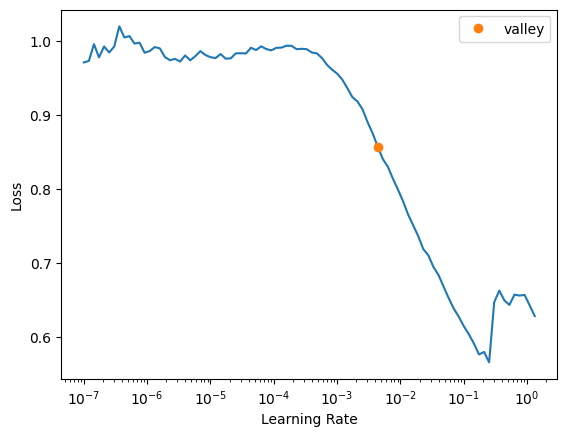

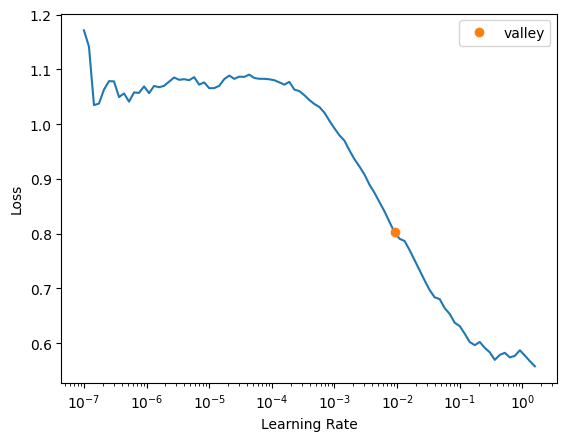

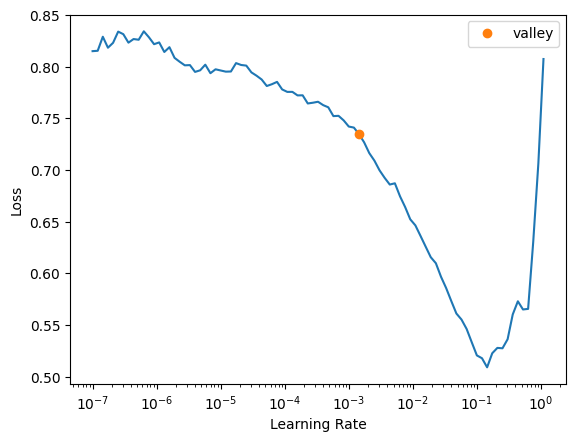

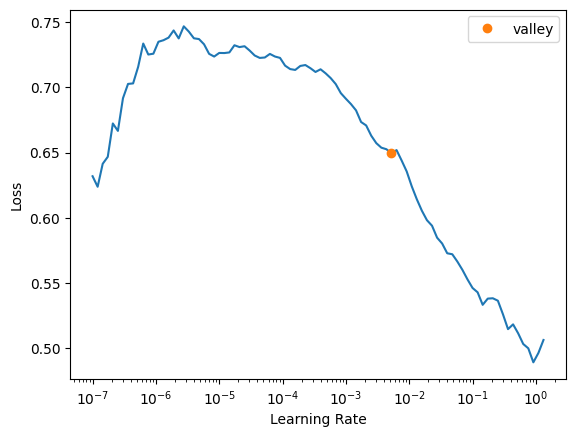

In [ ]:
#Pruebas, pero tampoco tendría que hacer mucho más ya en teoría.
for _, learner in learners['NAG'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)



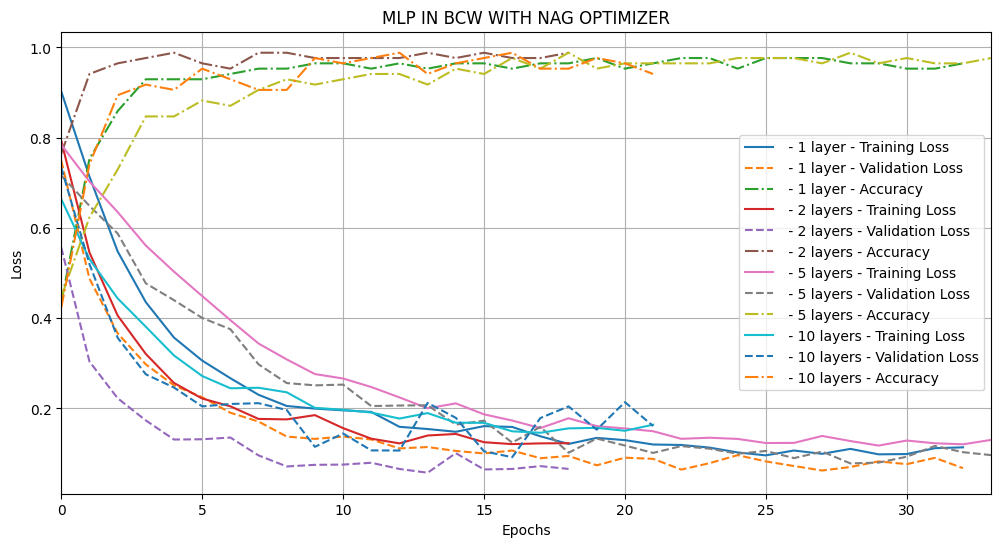

In [ ]:
utilsTFG.plot_learners_training(learners['NAG'].values(), title='MLP IN BCW WITH NAG OPTIMIZER', names=names_layer)

### RMSProp

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.281021,0.130254,0.976471,00:00
1,0.180089,0.094656,0.964706,00:00
2,0.160501,0.098825,0.964706,00:00
3,0.151058,0.150702,0.929412,00:00
4,0.181067,0.095041,0.964706,00:00
5,0.159033,0.083233,0.988235,00:00
6,0.131443,0.050597,0.976471,00:00
7,0.140651,0.070493,0.988235,00:00
8,0.135430,0.067463,0.988235,00:00
9,0.137870,0.115543,0.941176,00:00


Better model found at epoch 0 with valid_loss value: 0.13025438785552979.
Better model found at epoch 1 with valid_loss value: 0.0946560949087143.
Better model found at epoch 5 with valid_loss value: 0.08323308825492859.
Better model found at epoch 6 with valid_loss value: 0.05059656873345375.
No improvement since epoch 6: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.489076,0.444813,0.941176,00:00
1,0.354086,0.255267,0.976471,00:00
2,0.291413,0.176608,0.976471,00:00
3,0.218456,0.142885,0.952941,00:00
4,0.190965,0.113141,0.952941,00:00
5,0.174130,0.080869,0.988235,00:00
6,0.154910,0.100950,0.952941,00:00
7,0.143689,0.076731,0.988235,00:00
8,0.138801,0.118144,0.964706,00:00
9,0.115859,0.064415,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.4448131024837494.
Better model found at epoch 1 with valid_loss value: 0.25526708364486694.
Better model found at epoch 2 with valid_loss value: 0.1766083985567093.
Better model found at epoch 3 with valid_loss value: 0.14288479089736938.
Better model found at epoch 4 with valid_loss value: 0.11314134299755096.
Better model found at epoch 5 with valid_loss value: 0.08086908608675003.
Better model found at epoch 7 with valid_loss value: 0.07673092931509018.
Better model found at epoch 9 with valid_loss value: 0.06441497057676315.
Better model found at epoch 12 with valid_loss value: 0.06401510536670685.
Better model found at epoch 15 with valid_loss value: 0.04130377247929573.
No improvement since epoch 15: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.361881,0.369964,0.905882,00:00
1,0.292042,0.141090,0.941176,00:00
2,0.261868,0.116596,0.964706,00:00
3,0.226629,0.096691,0.976471,00:00
4,0.186630,0.084040,0.964706,00:00
5,0.192229,0.071059,0.976471,00:00
6,0.188209,0.134112,0.952941,00:00
7,0.178139,0.099070,0.964706,00:00
8,0.149725,0.098806,0.976471,00:00
9,0.173655,0.116864,0.964706,00:00


Better model found at epoch 0 with valid_loss value: 0.3699638247489929.
Better model found at epoch 1 with valid_loss value: 0.14108969271183014.
Better model found at epoch 2 with valid_loss value: 0.11659646779298782.
Better model found at epoch 3 with valid_loss value: 0.09669061750173569.
Better model found at epoch 4 with valid_loss value: 0.08403989672660828.
Better model found at epoch 5 with valid_loss value: 0.0710594430565834.
No improvement since epoch 5: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.406373,0.482397,0.800000,00:00
1,0.293050,0.278336,0.882353,00:00
2,0.253138,0.147356,0.952941,00:00
3,0.236560,0.253340,0.882353,00:00
4,0.239048,0.308312,0.858824,00:00
5,0.256333,0.240302,0.929412,00:00
6,0.241870,0.076978,1.000000,00:00
7,0.222475,0.255087,0.882353,00:00
8,0.211113,0.076157,0.988235,00:00
9,0.229635,0.204854,0.905882,00:00


Better model found at epoch 0 with valid_loss value: 0.4823969304561615.
Better model found at epoch 1 with valid_loss value: 0.2783356010913849.
Better model found at epoch 2 with valid_loss value: 0.14735645055770874.
Better model found at epoch 6 with valid_loss value: 0.07697810232639313.
Better model found at epoch 8 with valid_loss value: 0.0761573538184166.
No improvement since epoch 8: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

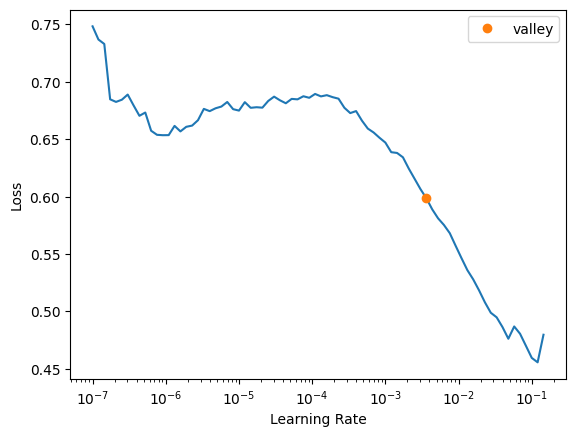

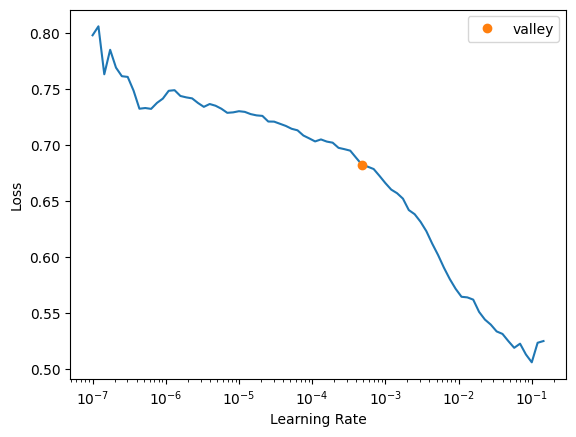

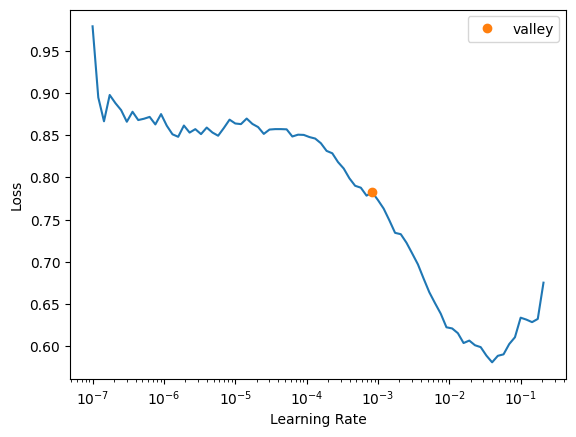

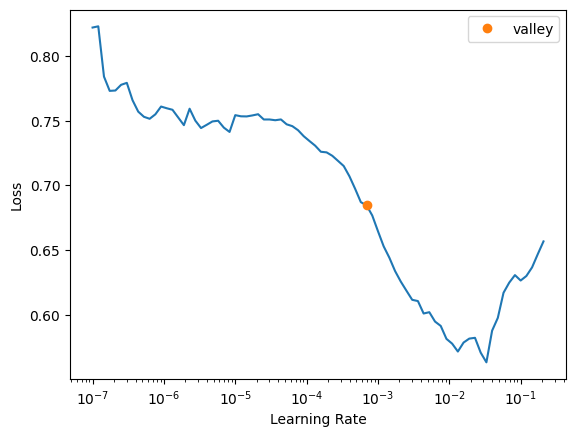

In [ ]:
for _, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)


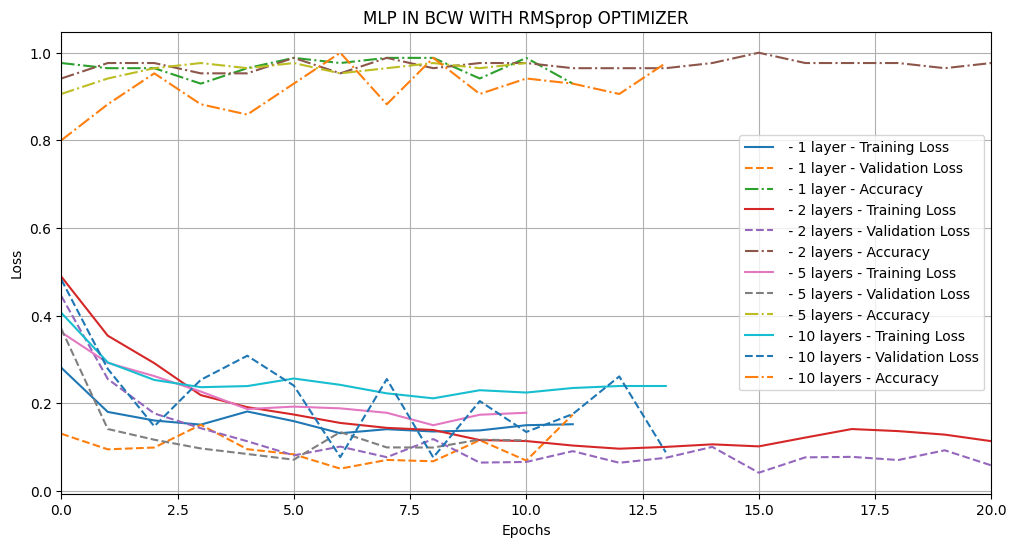

In [ ]:
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='MLP IN BCW WITH RMSprop OPTIMIZER', names=names_layer)

### Adam

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.592567,0.591607,0.776471,00:00
1,0.500321,0.453517,0.870588,00:00
2,0.429802,0.354211,0.917647,00:00
3,0.357739,0.266032,0.941176,00:00
4,0.311967,0.230211,0.941176,00:00
5,0.267570,0.160020,0.964706,00:00
6,0.224798,0.154106,0.976471,00:00
7,0.200235,0.134805,0.964706,00:00
8,0.160575,0.097104,0.988235,00:00
9,0.169122,0.091860,0.988235,00:00


Better model found at epoch 0 with valid_loss value: 0.5916069746017456.
Better model found at epoch 1 with valid_loss value: 0.4535166919231415.
Better model found at epoch 2 with valid_loss value: 0.35421106219291687.
Better model found at epoch 3 with valid_loss value: 0.26603150367736816.
Better model found at epoch 4 with valid_loss value: 0.23021091520786285.
Better model found at epoch 5 with valid_loss value: 0.16001972556114197.
Better model found at epoch 6 with valid_loss value: 0.15410557389259338.
Better model found at epoch 7 with valid_loss value: 0.13480478525161743.
Better model found at epoch 8 with valid_loss value: 0.09710433334112167.
Better model found at epoch 9 with valid_loss value: 0.09186040610074997.
Better model found at epoch 10 with valid_loss value: 0.08594824373722076.
Better model found at epoch 11 with valid_loss value: 0.08133072406053543.
Better model found at epoch 13 with valid_loss value: 0.07790203392505646.
Better model found at epoch 15 with v

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.610196,0.582127,0.788235,00:00
1,0.486172,0.370727,0.929412,00:00
2,0.406522,0.272451,0.905882,00:00
3,0.338888,0.218856,0.952941,00:00
4,0.300193,0.173875,0.988235,00:00
5,0.268933,0.153928,0.952941,00:00
6,0.222040,0.143588,0.952941,00:00
7,0.193409,0.117442,0.952941,00:00
8,0.177313,0.106378,0.976471,00:00
9,0.164136,0.138691,0.952941,00:00


Better model found at epoch 0 with valid_loss value: 0.582126796245575.
Better model found at epoch 1 with valid_loss value: 0.37072715163230896.
Better model found at epoch 2 with valid_loss value: 0.27245134115219116.
Better model found at epoch 3 with valid_loss value: 0.21885628998279572.
Better model found at epoch 4 with valid_loss value: 0.17387451231479645.
Better model found at epoch 5 with valid_loss value: 0.153927743434906.
Better model found at epoch 6 with valid_loss value: 0.14358766376972198.
Better model found at epoch 7 with valid_loss value: 0.11744224280118942.
Better model found at epoch 8 with valid_loss value: 0.10637761652469635.
Better model found at epoch 11 with valid_loss value: 0.08232415467500687.
Better model found at epoch 15 with valid_loss value: 0.08200965076684952.
Better model found at epoch 16 with valid_loss value: 0.06525196135044098.
Better model found at epoch 19 with valid_loss value: 0.06383635848760605.
Better model found at epoch 23 with va

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.582314,0.603595,0.658824,00:00
1,0.442776,0.337789,0.894118,00:00
2,0.359249,0.257584,0.929412,00:00
3,0.305173,0.207320,0.929412,00:00
4,0.263723,0.161235,0.964706,00:00
5,0.233091,0.174318,0.929412,00:00
6,0.202367,0.155740,0.952941,00:00
7,0.194175,0.127984,0.941176,00:00
8,0.166056,0.152136,0.929412,00:00
9,0.190090,0.167384,0.941176,00:00


Better model found at epoch 0 with valid_loss value: 0.6035954356193542.
Better model found at epoch 1 with valid_loss value: 0.3377886116504669.
Better model found at epoch 2 with valid_loss value: 0.2575837969779968.
Better model found at epoch 3 with valid_loss value: 0.20732031762599945.
Better model found at epoch 4 with valid_loss value: 0.16123484075069427.
Better model found at epoch 6 with valid_loss value: 0.15574026107788086.
Better model found at epoch 7 with valid_loss value: 0.12798403203487396.
Better model found at epoch 11 with valid_loss value: 0.10640078037977219.
Better model found at epoch 12 with valid_loss value: 0.07864458113908768.
Better model found at epoch 16 with valid_loss value: 0.048534512519836426.
No improvement since epoch 16: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.473822,0.649864,0.517647,00:00
1,0.366404,0.332262,0.847059,00:00
2,0.296843,0.243725,0.905882,00:00
3,0.274949,0.255666,0.870588,00:00
4,0.245647,0.227989,0.882353,00:00
5,0.230579,0.245387,0.917647,00:00
6,0.248072,0.197250,0.929412,00:00
7,0.218393,0.167936,0.929412,00:00
8,0.234138,0.336268,0.847059,00:00
9,0.227205,0.195830,0.929412,00:00


Better model found at epoch 0 with valid_loss value: 0.6498644948005676.
Better model found at epoch 1 with valid_loss value: 0.3322620391845703.
Better model found at epoch 2 with valid_loss value: 0.24372504651546478.
Better model found at epoch 4 with valid_loss value: 0.2279885858297348.
Better model found at epoch 6 with valid_loss value: 0.1972496062517166.
Better model found at epoch 7 with valid_loss value: 0.1679358333349228.
Better model found at epoch 12 with valid_loss value: 0.12483319640159607.
Better model found at epoch 14 with valid_loss value: 0.1103246659040451.
Better model found at epoch 18 with valid_loss value: 0.09382986277341843.
No improvement since epoch 18: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

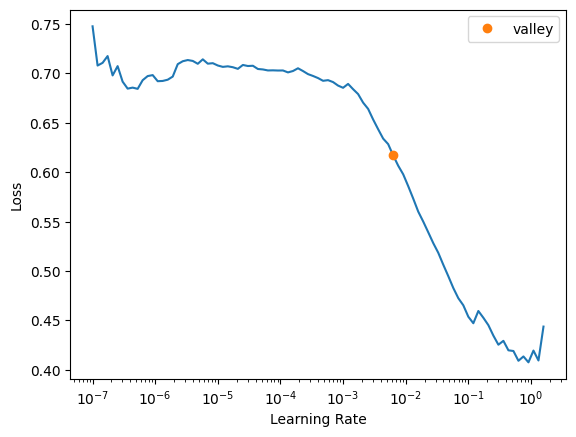

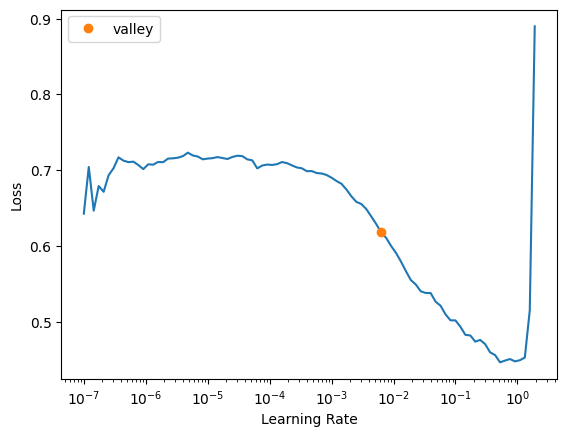

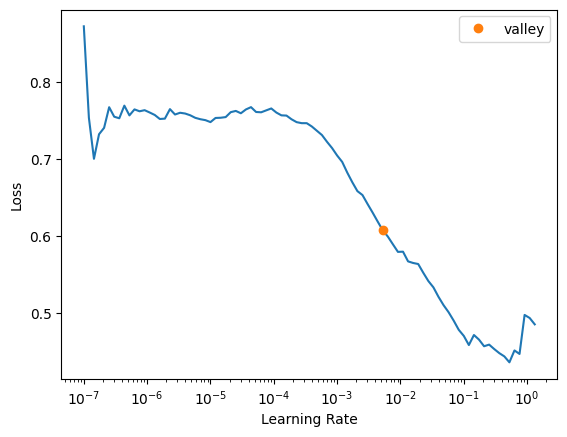

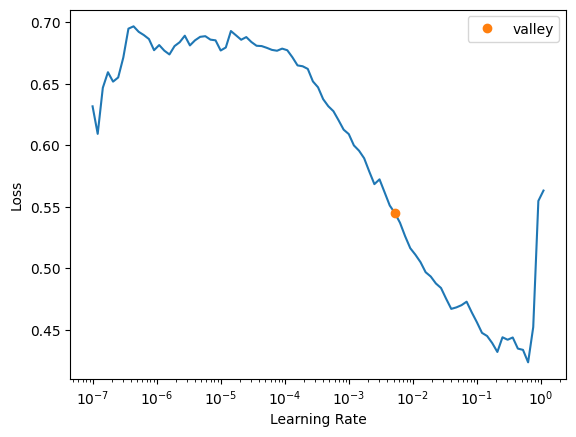

In [ ]:
for _, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)


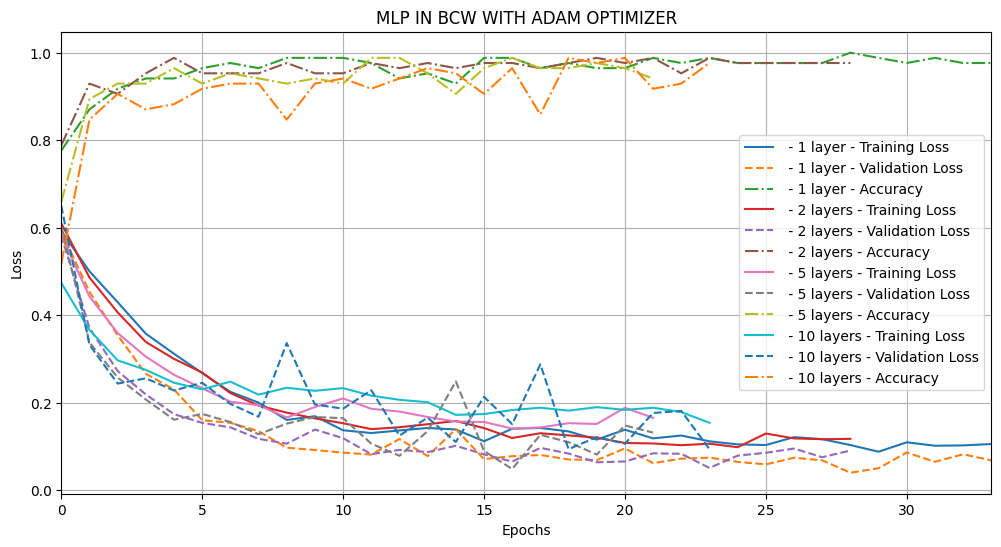

In [ ]:
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='MLP IN BCW WITH ADAM OPTIMIZER', names=names_layer)

### Generalization

In [ ]:
#Save the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(learners, f)

In [ ]:
#Load the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'rb') as f:
    learners = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/learners_dict.pkl'

In [ ]:
#Run the model in the test set
n_layers=[1,2,5,10]
for optim in optims:
  for layer in n_layers:
    loss, accuracy = learners[optim][layer].validate(dl=test_dl)
    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Accuracy: {accuracy}")

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [ ]:
#Run the model in the test set
n_layers=[1,2,5,10]
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)

    loss = F.cross_entropy(preds, targs.long().squeeze())

    # Calculate accuracy
    accuracy = (preds.argmax(dim=1) == targs).float().mean()

    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss.item()}, Accuracy: {accuracy.item()}")

Optimizer: NAG, Layers: 1, Loss: 0.3641989529132843, Accuracy: 0.5038062334060669


Optimizer: NAG, Layers: 2, Loss: 0.3668813407421112, Accuracy: 0.5031141638755798


Optimizer: NAG, Layers: 5, Loss: 0.3614906668663025, Accuracy: 0.5031141638755798


Optimizer: NAG, Layers: 10, Loss: 0.39551302790641785, Accuracy: 0.5044982433319092


Optimizer: RMSProp, Layers: 1, Loss: 0.3666214942932129, Accuracy: 0.5038062334060669


Optimizer: RMSProp, Layers: 2, Loss: 0.35535356402397156, Accuracy: 0.5031141638755798


Optimizer: RMSProp, Layers: 5, Loss: 0.35924583673477173, Accuracy: 0.5031141638755798


Optimizer: RMSProp, Layers: 10, Loss: 0.37565115094184875, Accuracy: 0.5044982433319092


Optimizer: ADAM, Layers: 1, Loss: 0.35354167222976685, Accuracy: 0.5031141638755798


Optimizer: ADAM, Layers: 2, Loss: 0.36469700932502747, Accuracy: 0.5038062334060669


Optimizer: ADAM, Layers: 5, Loss: 0.36108657717704773, Accuracy: 0.5017300844192505


Optimizer: ADAM, Layers: 10, Loss: 0.4287126958370209, Accuracy: 0.5058823823928833


### Comparative per layers

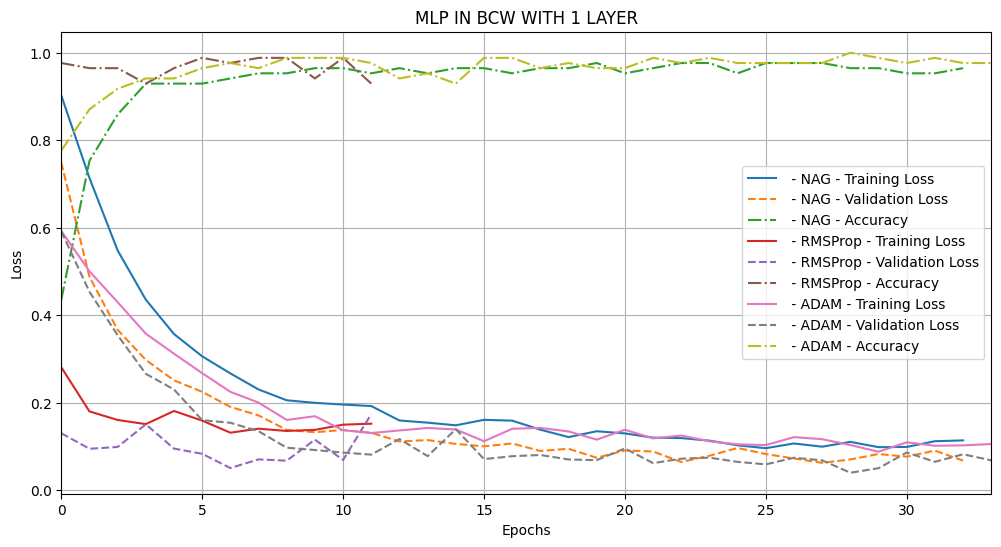

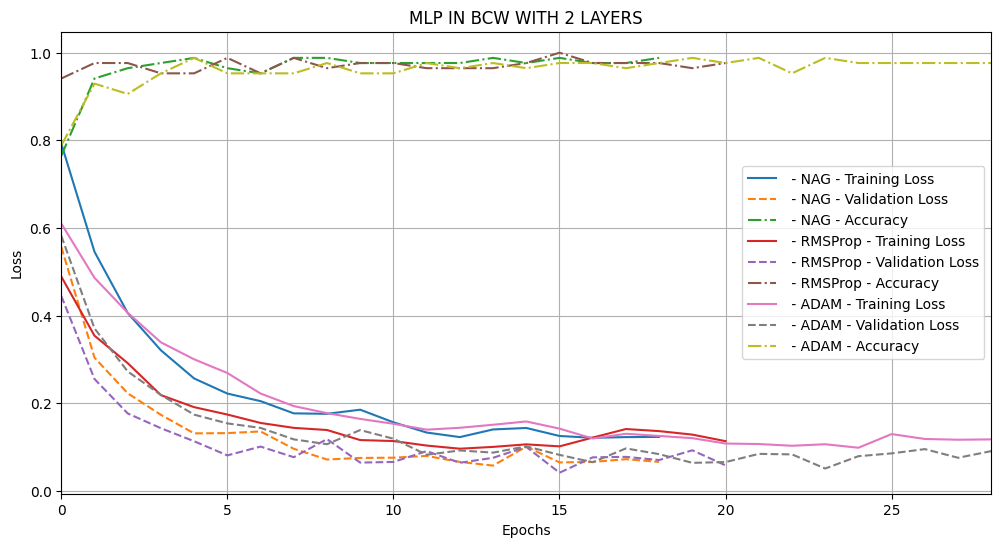

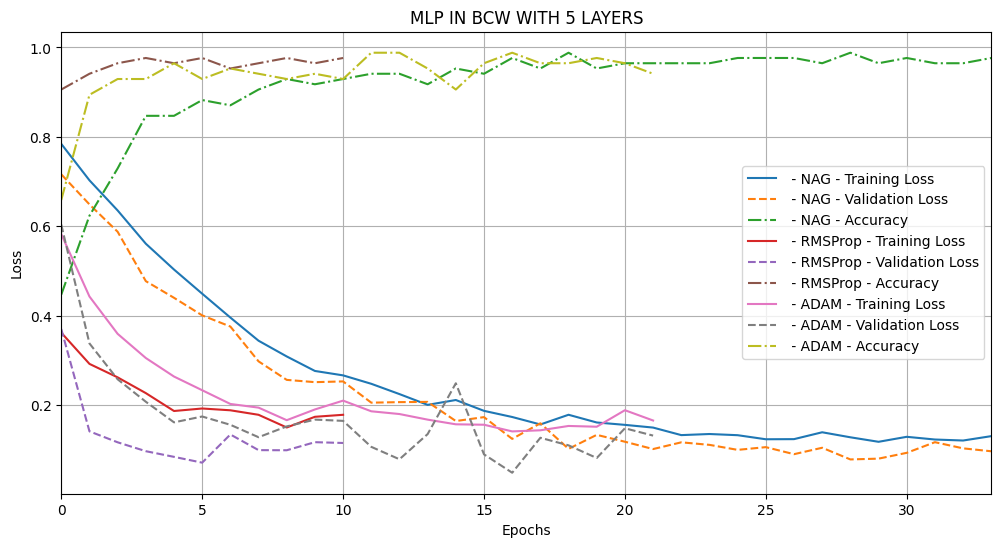

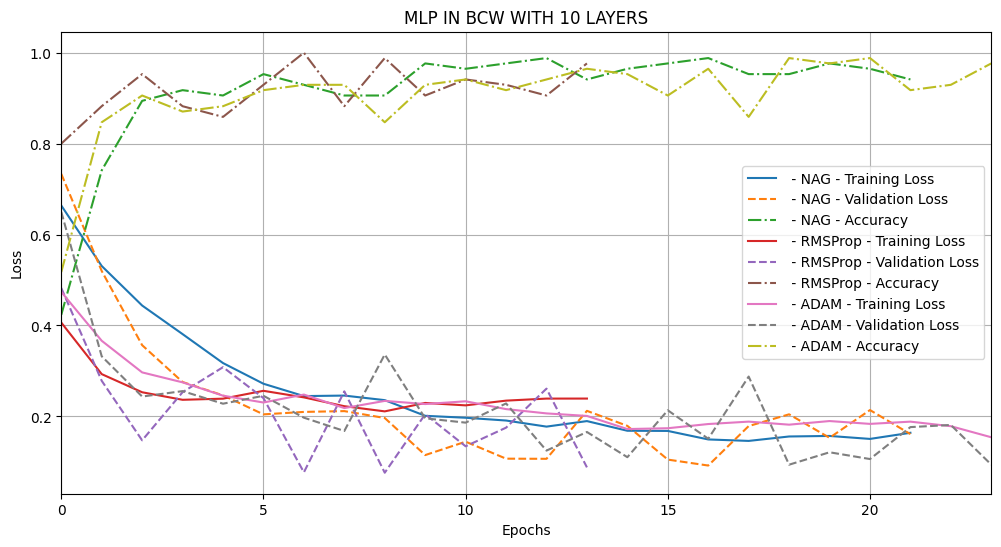

In [ ]:
#Compare the three optimizers in each layer version

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_10_layers = [learners['NAG'][10], learners['RMSProp'][10], learners['ADAM'][10]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title='MLP IN BCW WITH 1 LAYER', names=names)
utilsTFG.plot_learners_training(learners_2_layers, title='MLP IN BCW WITH 2 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_5_layers, title='MLP IN BCW WITH 5 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_10_layers, title='MLP IN BCW WITH 10 LAYERS', names=names)

## Metaheuristics

In [ ]:
import copy
#layer=[16,32,64, 64,32,16]
pop_size=10
population = {}
fitness = {}
mh_learners = {}

for n_layer,layer in zip(n_layers,layers) :
  population[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, cbs=[SaveModelCallback()])
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.reset_weights)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))



### Genetic Algorithms

In [ ]:
#Para la capa más pequeña (32) no me mejora nada el gen_alg. He probado: 1-point, blx-alpha con mutacion, blx-alpha sin mutacion y el crossover de capas. Podria probar en la capa más grande a ver si hay diferencia.
models = {}
models['GA'] = {}
for layer in layers:
  models['GA'][len(layer)] = utilsTFG.gen_alg(10, population, dls_mh, 4000, tabular_learner(dls_mh, layers=layer))

KeyboardInterrupt: 

### SHADE

In [ ]:
#SHADE alg
pop_copy= copy.copy(population)

fitness = [utilsTFG.err_param(ind, gustavo.model, dls) for ind in pop_copy]
res_shade = utilsTFG.SHADE_ej(pop_copy, fitness, 10, 4000, len(pop_copy[0]), dls_mh, model=gustavo.model)

KeyboardInterrupt: 

### SHADE-ILS

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
pop_copy= copy.deepcopy(population)

res_gen = utilsTFG.gen_alg(10, pop_copy, dls, 4000, gustavo)

In [ ]:
#SHADE-ILS
pop_copy= copy.copy(population)
#Nota:funciona mejor con la inicialización de arriba y los parámetros tal como están, permitiendo peores soluciones a veces. (2 pruebas y sale todo genia)

#fitness = [utilsTFG.err_param(ind, gustavo.model, dls_mh) for ind in pop_copy]
res_shade_ils = utilsTFG.SHADE_ILS(pop_copy, 1000, 200, dls, gustavo, gustavo.model, max_ls=200)

eo
deque([1, 0.600019691669396, 0.3312320514457899], maxlen=3)
deque([0.600019691669396, 0.3312320514457899, -0.005972602085139361], maxlen=3)
233
eo
deque([0.3312320514457899, -0.005972602085139361, 0.04735662488256552], maxlen=3)
deque([-0.005972602085139361, 0.04735662488256552, -0.24822811821338003], maxlen=3)
Reiniciado
453
eo
deque([1, 1, 0.6302820025869577], maxlen=3)
deque([1, 0.6302820025869577, 0.6549943260718102], maxlen=3)
669
eo
deque([0.6302820025869577, 0.6549943260718102, 0.06482424871524972], maxlen=3)
deque([0.6549943260718102, 0.06482424871524972, 0.19312088999105506], maxlen=3)
881
eo
deque([0.06482424871524972, 0.19312088999105506, 0.0], maxlen=3)
deque([0.19312088999105506, 0.0, -0.10143849091423754], maxlen=3)
1090


In [ ]:
res_shade_ils[2]

[0.6668252944946289,
 0.26671698689460754,
 0.17943711578845978,
 0.17943711578845978,
 0.17943711578845978,
 0.14792487025260925,
 0.14792487025260925]

In [ ]:
fit_valid = [utilsTFG.err_param_valid(ind, gustavo.model, dls) for ind in res_shade_ils[3]]

In [ ]:
fit_valid

[0.7342472076416016,
 0.16517798602581024,
 0.21776457130908966,
 0.21776457130908966,
 0.21776457130908966,
 0.1148078516125679,
 0.1148078516125679]

deque([1, 1, 0.877925078287569], maxlen=3)
eo
deque([1, 0.877925078287569, 0.0], maxlen=3)
deque([0.877925078287569, 0.0, 0.6698967049606931], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.258463,0.330150,00:00


deque([0.0, 0.6698967049606931, -8.399270135043645], maxlen=3)
eo
deque([0.6698967049606931, -8.399270135043645, 0.0], maxlen=3)
deque([-8.399270135043645, 0.0, 0.6865987649533412], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.161981,0.171653,00:00


deque([0.0, 0.6865987649533412, -17.795750964393104], maxlen=3)
eo
deque([0.6865987649533412, -17.795750964393104, 0.0], maxlen=3)
deque([-17.795750964393104, 0.0, 0.8370485810323631], maxlen=3)
deque([0.0, 0.8370485810323631, 0.0], maxlen=3)
eo
deque([0.8370485810323631, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.6048730857919355], maxlen=3)
deque([0.0, 0.6048730857919355, 0.0], maxlen=3)
eo
deque([0.6048730857919355, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.3954038029144446], maxlen=3)
deque([0.0, 0.3954038029144446, 0.0], maxlen=3)
eo
deque([0.3954038029144446, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.23316823085175287], maxlen=3)
deque([0.0, 0.23316823085175287, 0.0], maxlen=3)
eo
deque([0.23316823085175287, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.42908933738314625], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.083229,0.223628,00:00


deque([0.0, 0.42908933738314625, -565.6813723892287], maxlen=3)
eo
deque([0.42908933738314625, -565.6813723892287, 0.0], maxlen=3)
deque([-565.6813723892287, 0.0, 0.3101249587455517], maxlen=3)
deque([0.0, 0.3101249587455517, 0.0], maxlen=3)
eo
deque([0.3101249587455517, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.2372279221911396], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.048070,0.197187,00:00


deque([0.0, 0.2372279221911396, -620.9764814158599], maxlen=3)
eo
deque([0.2372279221911396, -620.9764814158599, 0.0], maxlen=3)
deque([-620.9764814158599, 0.0, 0.17259529876856372], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.036670,0.241103,00:00


deque([0.0, 0.17259529876856372, -572.45066789369], maxlen=3)
eo
deque([0.17259529876856372, -572.45066789369, 0.0], maxlen=3)
deque([-572.45066789369, 0.0, 0.2945547199038225], maxlen=3)
deque([0.0, 0.2945547199038225, 0.0], maxlen=3)
eo
deque([0.2945547199038225, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.2940660387454382], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.019462,0.252269,00:00


deque([0.0, 0.2940660387454382, -610.1349420892426], maxlen=3)
eo
deque([0.2940660387454382, -610.1349420892426, 0.0], maxlen=3)
deque([-610.1349420892426, 0.0, 0.2247509154851943], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.028347,0.257762,00:00


deque([0.0, 0.2247509154851943, -1147.1959141847803], maxlen=3)
eo
deque([0.2247509154851943, -1147.1959141847803, 0.01745781927122387], maxlen=3)
deque([-1147.1959141847803, 0.01745781927122387, 0.22581496640490026], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.014434,0.287010,00:00


deque([0.01745781927122387, 0.22581496640490026, -767.5841035062855], maxlen=3)
eo
deque([0.22581496640490026, -767.5841035062855, 0.0007587110842139276], maxlen=3)
deque([-767.5841035062855, 0.0007587110842139276, 0.2004751239669822], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.009739,0.294235,00:00


deque([0.0007587110842139276, 0.2004751239669822, -648.1095434374148], maxlen=3)
eo
deque([0.2004751239669822, -648.1095434374148, 0.0], maxlen=3)
deque([-648.1095434374148, 0.0, 0.3965007103148876], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.005940,0.294435,00:00


deque([0.0, 0.3965007103148876, -655.0476876580542], maxlen=3)
eo
deque([0.3965007103148876, -655.0476876580542, 0.004808824273905102], maxlen=3)
deque([-655.0476876580542, 0.004808824273905102, 0.14387962179237823], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.004525,0.327886,00:00


deque([0.004808824273905102, 0.14387962179237823, -585.5378881302172], maxlen=3)
eo
deque([0.14387962179237823, -585.5378881302172, 0.0027863461728001495], maxlen=3)
deque([-585.5378881302172, 0.0027863461728001495, 0.0], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.003589,0.364360,00:00


deque([0.0027863461728001495, 0.0, -465.5142218862528], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7465006848020665], maxlen=3)
deque([1, 0.7465006848020665, 0.8902095689854549], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.409966,0.295649,00:00


deque([0.7465006848020665, 0.8902095689854549, -5.1419537235982276], maxlen=3)
eo
deque([0.8902095689854549, -5.1419537235982276, 0.0], maxlen=3)
deque([-5.1419537235982276, 0.0, 0.8435254064122947], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.268251,0.219626,00:00


deque([0.0, 0.8435254064122947, -24.68362966815737], maxlen=3)


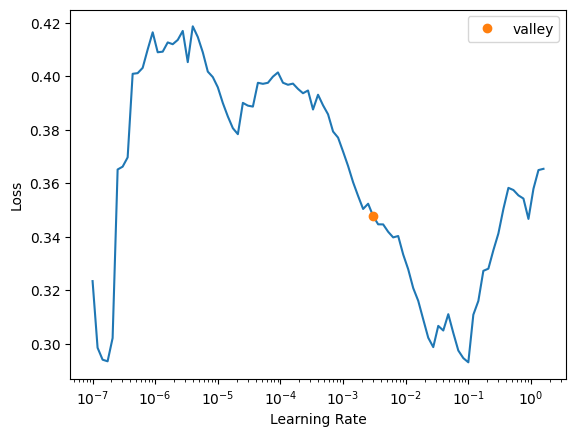

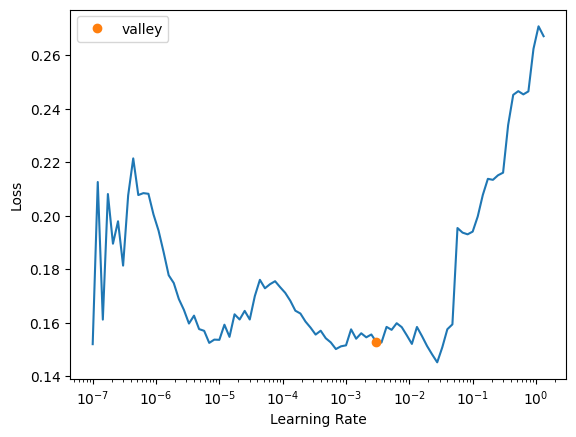

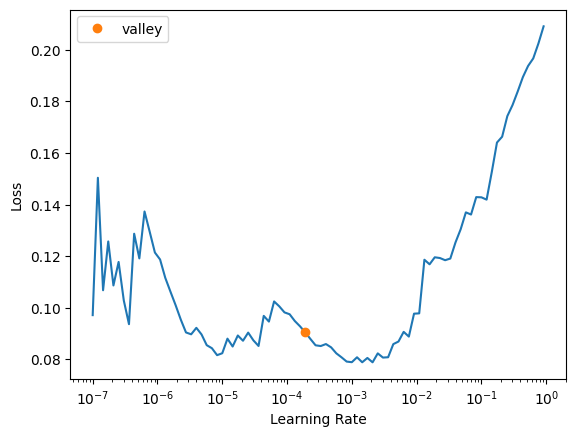

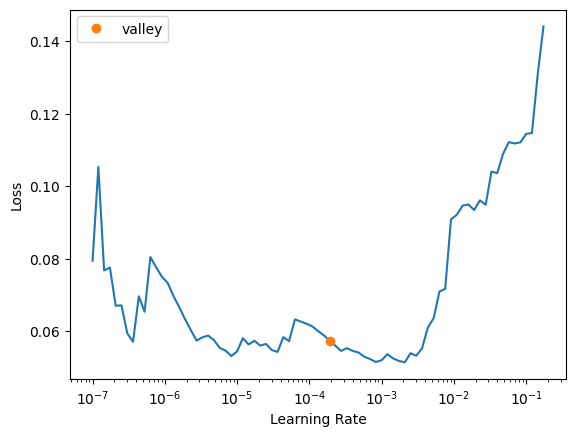

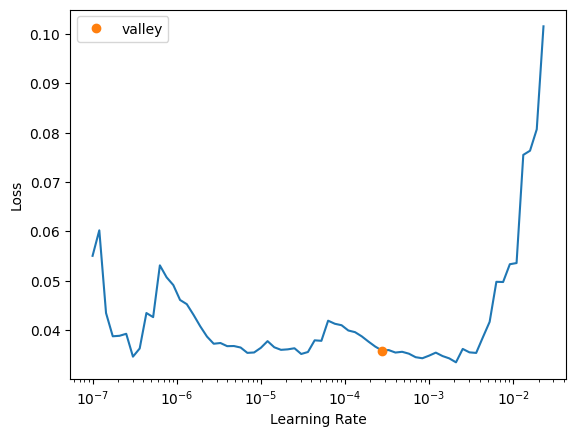

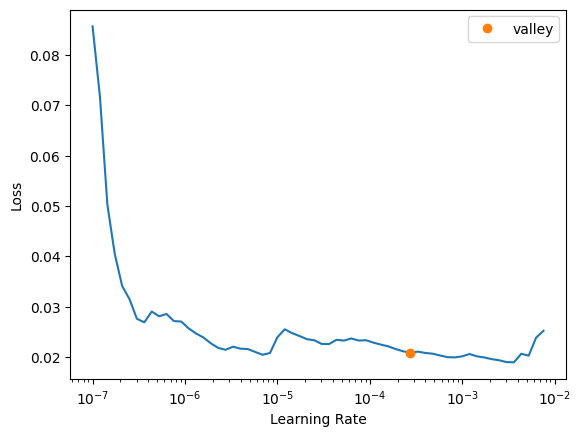

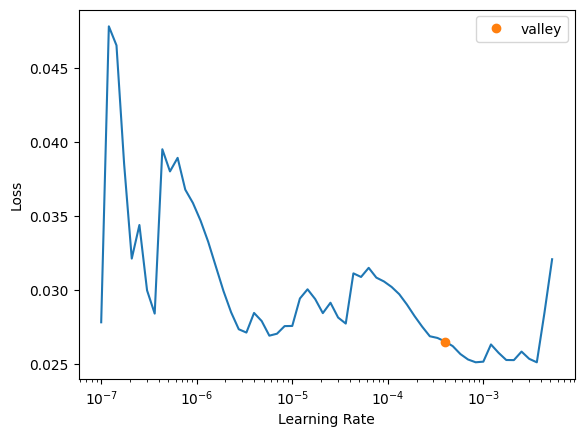

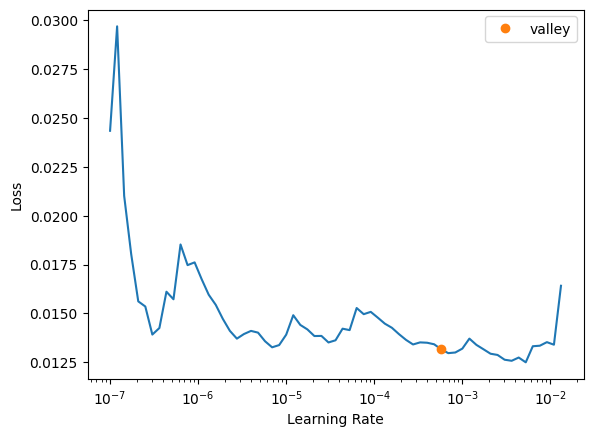

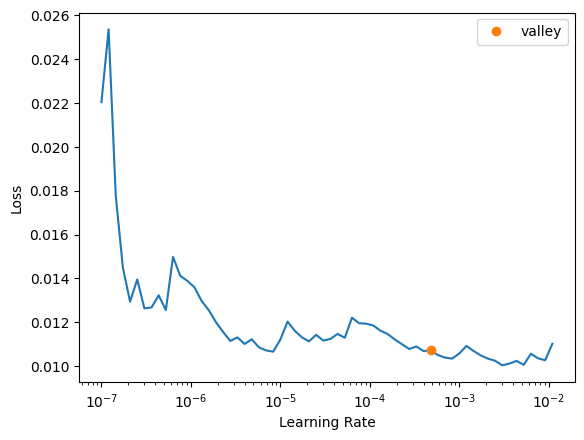

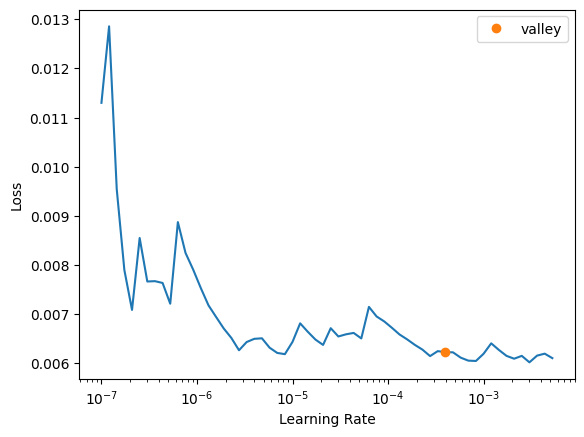

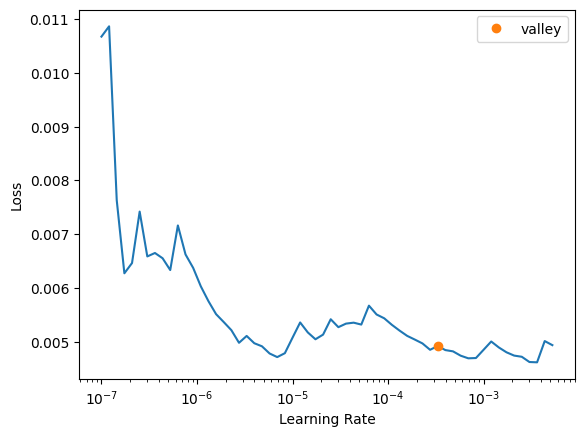

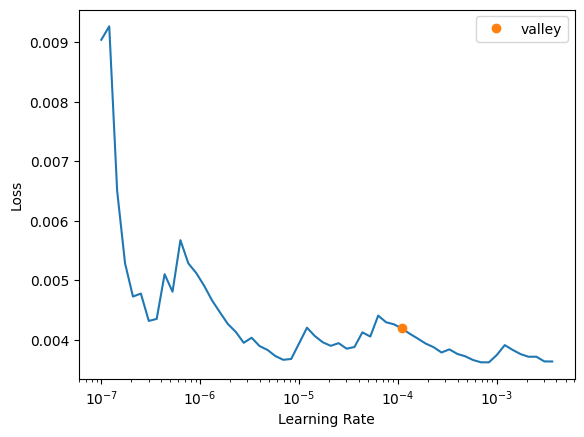

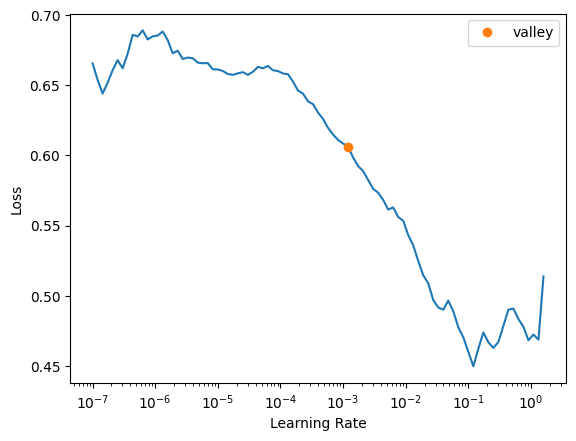

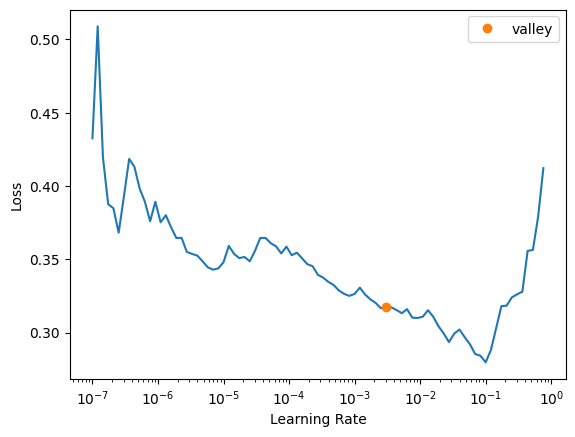

In [ ]:
#population = [utilsTFG.get_params_from_model(tabular_learner(dls, layers=layer)) for _ in range(10)]
pop_copy= copy.copy(population)
#podria cargar los parametros del otro aqui, en teoria deberia tener la misma cantidad y distribucion de parametros
fitness = [utilsTFG.err_param(ind, gustavo.model, dls) for ind in population]
gustavo=tabular_learner(dls, layers=layer)
res_shade_ils_gd = utilsTFG.SHADE_ILS_GD(pop_copy,4000, 200, dls, gustavo, gustavo.model)

eo
deque([1, 1, 0.07845795547900195], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.469824,0.404232,00:00


deque([1, 0.07845795547900195, 0.2367963913081324], maxlen=3)
eo
deque([0.07845795547900195, 0.2367963913081324, 0.14053793224364722], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.309818,0.322416,00:00


deque([0.2367963913081324, 0.14053793224364722, 0.23273532933371585], maxlen=3)
eo
deque([0.14053793224364722, 0.23273532933371585, 0.16651218072584922], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.248504,0.444112,00:00


deque([0.23273532933371585, 0.16651218072584922, 0.037660884692984654], maxlen=3)
eo
deque([0.16651218072584922, 0.037660884692984654, 0.3478394718234525], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.149014,0.170993,00:00


deque([0.037660884692984654, 0.3478394718234525, 0.08052983169703665], maxlen=3)
eo
deque([0.3478394718234525, 0.08052983169703665, 0.39697630263413286], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.085013,0.236796,00:00


deque([0.08052983169703665, 0.39697630263413286, 0.05393169717968626], maxlen=3)
eo
deque([0.39697630263413286, 0.05393169717968626, 0.0], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.073193,0.260025,00:00


deque([0.05393169717968626, 0.0, 0.13902981308028708], maxlen=3)
eo
deque([0.0, 0.13902981308028708, 0.0], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.063226,0.254425,00:00


deque([0.13902981308028708, 0.0, 0.13617776192517872], maxlen=3)
eo
deque([0.0, 0.13617776192517872, 0.0], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.055922,0.261946,00:00


deque([0.13617776192517872, 0.0, 0.11551684600417061], maxlen=3)
eo
deque([0.0, 0.11551684600417061, 0.009889529603672056], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.051253,0.256278,00:00


deque([0.11551684600417061, 0.009889529603672056, 0.07434174460253046], maxlen=3)
eo
deque([0.009889529603672056, 0.07434174460253046, 0.016043969350774366], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.084309,0.232322,00:00


deque([0.07434174460253046, 0.016043969350774366, -0.6717833580081957], maxlen=3)
eo
deque([0.016043969350774366, -0.6717833580081957, 0.0], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.071425,0.243445,00:00


deque([-0.6717833580081957, 0.0, -0.4162960758917115], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.693699465632171], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.275238,0.197457,00:00


deque([1, 0.693699465632171, 0.544264457903026], maxlen=3)
eo
deque([0.693699465632171, 0.544264457903026, 0.1747627732563201], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.193333,0.224949,00:00


deque([0.544264457903026, 0.1747627732563201, 0.14882446284513765], maxlen=3)
eo
deque([0.1747627732563201, 0.14882446284513765, 0.12327449458691189], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.153027,0.163712,00:00


deque([0.14882446284513765, 0.12327449458691189, 0.09718886439848312], maxlen=3)
eo
deque([0.12327449458691189, 0.09718886439848312, 0.21645277183648012], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.125134,0.150500,00:00


deque([0.09718886439848312, 0.21645277183648012, -0.04362151332680387], maxlen=3)
eo
deque([0.21645277183648012, -0.04362151332680387, 0.1745527895436124], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.094466,0.207718,00:00


deque([-0.04362151332680387, 0.1745527895436124, 0.045547712256133126], maxlen=3)
eo
deque([0.1745527895436124, 0.045547712256133126, 0.10213571509244554], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.078781,0.165352,00:00


deque([0.045547712256133126, 0.10213571509244554, 0.07117423061212837], maxlen=3)
eo
deque([0.10213571509244554, 0.07117423061212837, 0.29974099186110875], maxlen=3)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,time
0,0.048938,0.196893,00:00


deque([0.07117423061212837, 0.29974099186110875, 0.11290769350864176], maxlen=3)
eo
deque([0.29974099186110875, 0.11290769350864176, 0.0383860749930215], maxlen=3)
deque([0.11290769350864176, 0.0383860749930215, 0.0], maxlen=3)
eo
deque([0.0383860749930215, 0.0, 0.12027476746487235], maxlen=3)
deque([0.0, 0.12027476746487235, 0.0], maxlen=3)


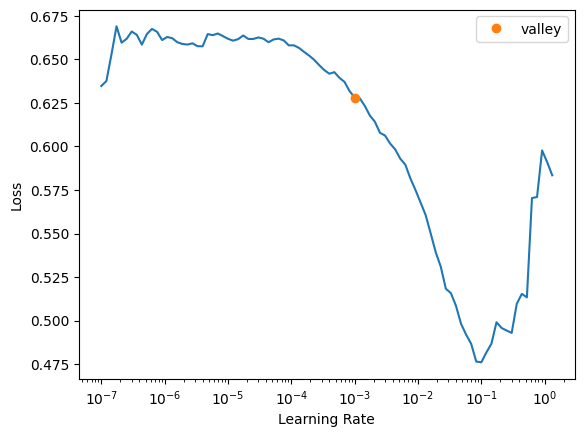

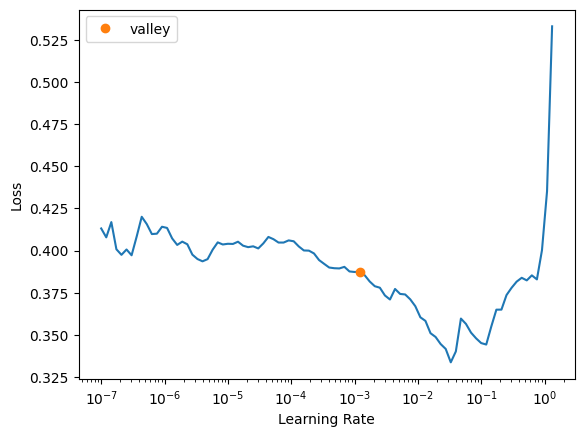

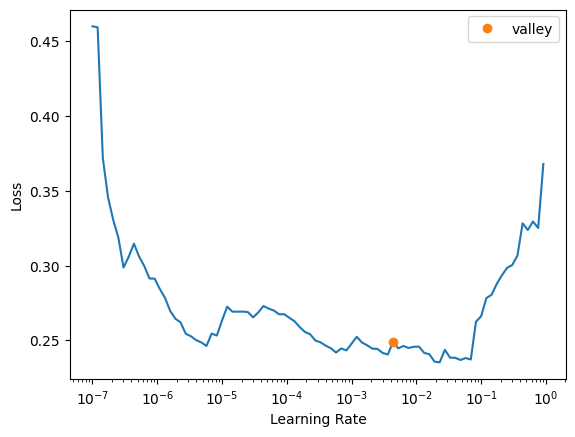

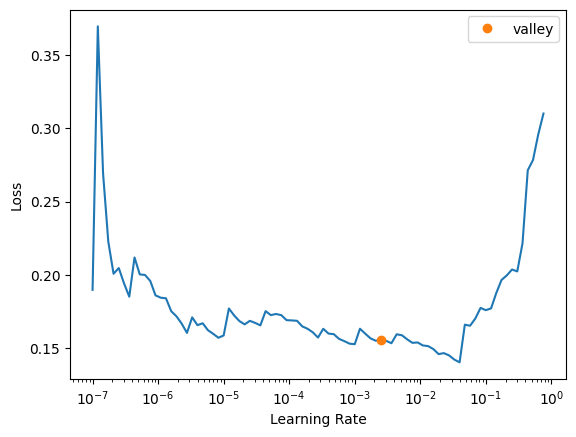

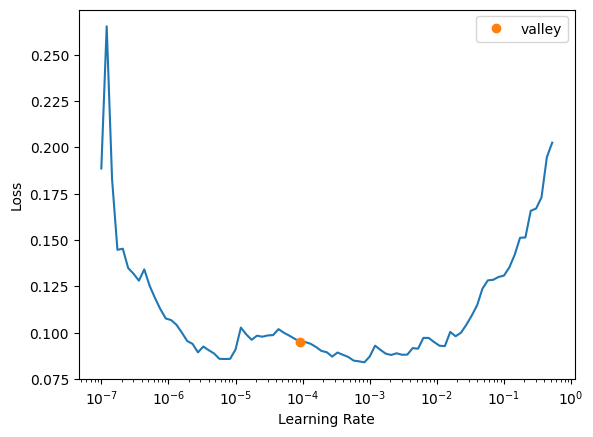

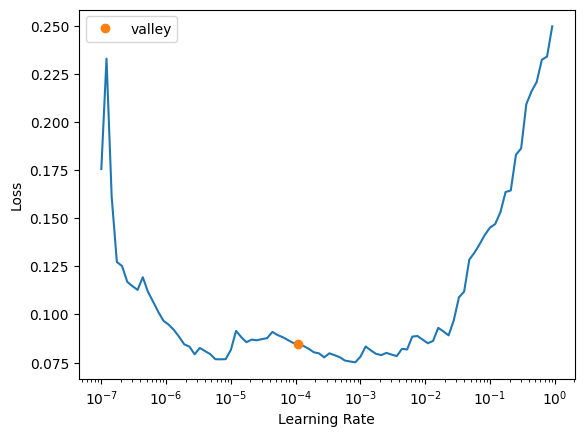

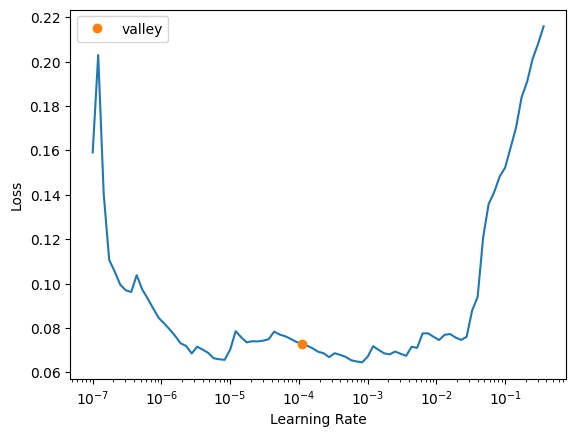

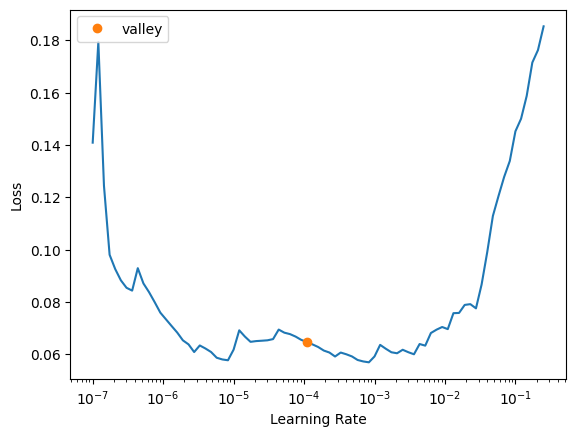

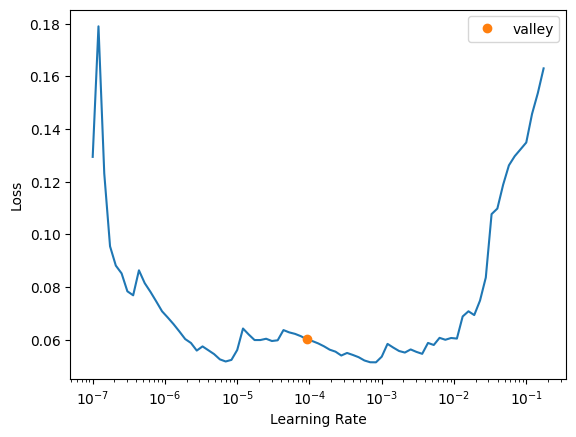

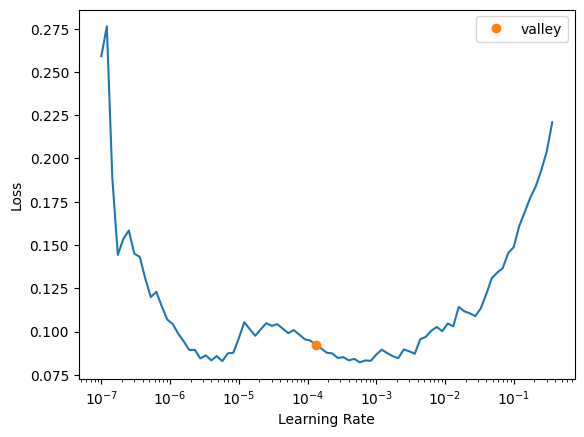

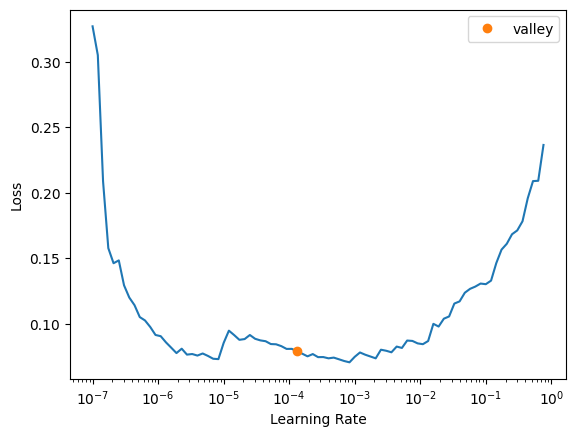

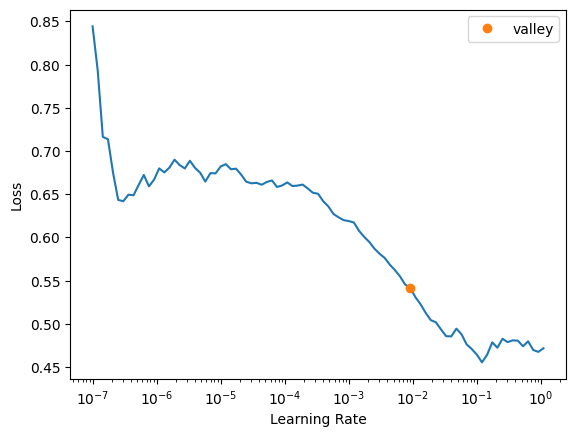

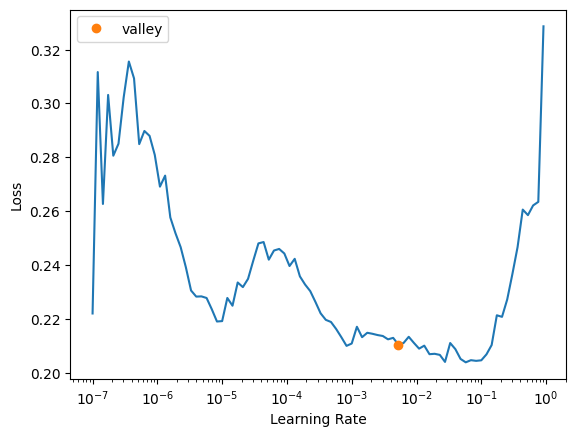

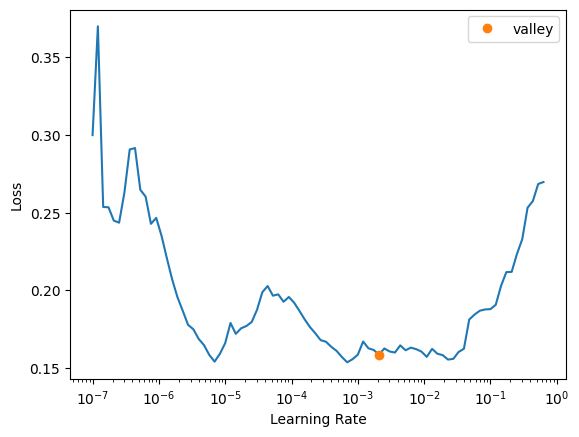

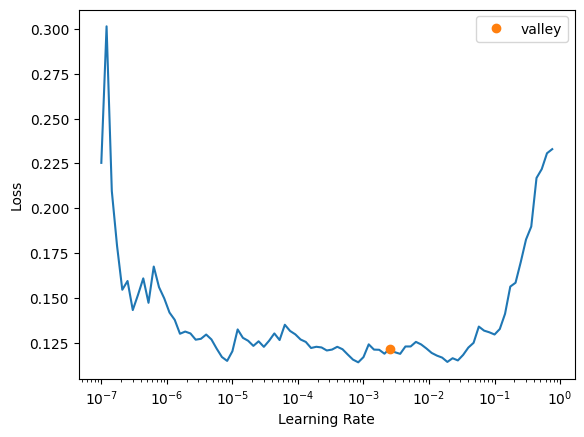

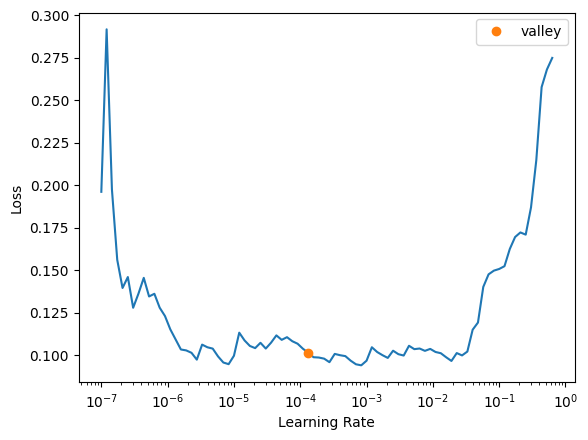

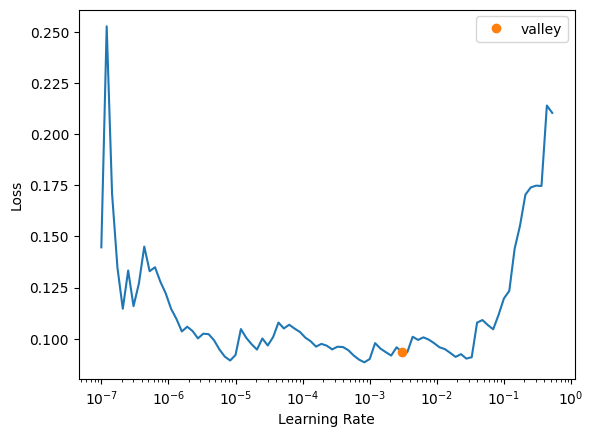

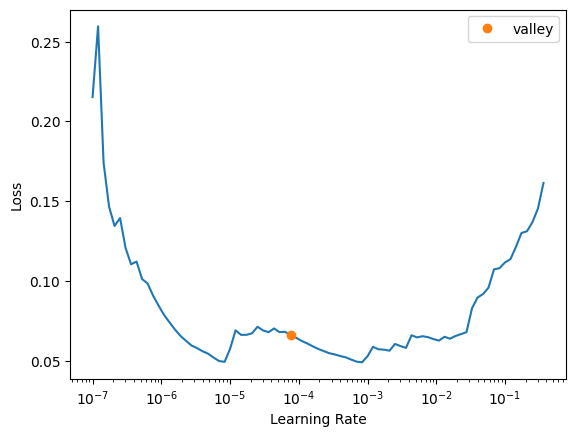

In [ ]:
#population = [utilsTFG.get_params_from_model(tabular_learner(dls, layers=layer)) for _ in range(10)]
pop_copy= copy.copy(population)
#podria cargar los parametros del otro aqui, en teoria deberia tener la misma cantidad y distribucion de parametros
fitness = [utilsTFG.err_param(ind, gustavo.model, dls) for ind in population]
gustavo=tabular_learner(dls, layers=layer)
res_shade_gd = utilsTFG.SHADE_GD(pop_copy,4000, 200, dls, gustavo, gustavo.model)

In [ ]:
res_shade_gd

(array([1.0105411 , 0.9829145 , 1.0005462 , ..., 0.39024433, 0.35198322,
        0.0984766 ], dtype=float32),
 array(0.04139963),
 [0.6680042147636414,
  array(0.46982354),
  array(0.30981803),
  array(0.2485044),
  array(0.14901371),
  array(0.08501256),
  array(0.07319328),
  array(0.06322598),
  array(0.05592232),
  array(0.05125302),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.05043072),
  array(0.04893828),
  array(0.04705973),
  array(0.04139963)])